# Genetiske algoritmer for å løse TSP

## Problemdefinisjon
Gitt et sett av byer og distansene mellom hvert par av byer, finn den korteste ruten som besøker alle byene nøyaktig én gang, og som returnerer til startpunktet. 

## Løsning
Vi skal løse dette med en genetisk algoritme. Før vi begynner kan det være lurt å tenke gjennom alle komponentene vi trenger. 
1. En by og et sett med byer
2. Et mål på distanse mellom byer 
3. En løsning på problemet, dvs. en rute for å reise mellom byene
4. Validering og plotting av en rute 

#### 1. Byer 
Vi må definere en by og representere et sett med byer. I dette problemet er en by gitt av et (x,y)-koordinat, og vi velger å representere en by som et klasse-objekt `City`. Vi tar ikke inn noen liste av byer, men vi generer dem tilfeldig. Likevel passer vi på reproduserbarhet ved å ta inn et seed og re-instansiere seedet i metoden, slik at hver gang vi kaller metoden med samme parametre, får det samme resultatet ut. 

In [1]:
from dataclasses import dataclass
import random
import numpy as np

seed = 42
np.random.seed(seed)
random.seed(seed)

@dataclass(eq=True, frozen=True)
class City:
    "Representing a city or a place, characterized by a (x,y)-coordinate"
    x: float
    y: float
    name: str

def generate_cities(
    n: int, width: int = 900, height: int = 600, seed: int = seed
) -> list[City]:
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset(
        City(
            x=random.randrange(width),
            y=random.randrange(height),
            name=chr(c + 97).upper(),
        )
        for c in range(n)
    )

#### 2. Et distansemål og fitness-funksjon
Vi trenger et mål på hvor god en løsning er. Her er målet vårt å finne den _korteste ruten_ gitt et sett med byer, så det vil være naturlig for oss å definere en fitness score basert på total distanse man må reise mellom ruter. Merk at problemet kan kompliseres ytterligere ved å optimere på tid brukt mellom byer over distanse eller lignende. 
For å kunne måle total distanse i en rute, lager vi en funksjon `total_distance(tour)`. Denne funksjonen trenger en funksjon for å måle distansen mellom hver etterfølgende by, så vi definerer `distance(city, city)` for det.  

In [2]:
def distance(A: City, B: City):
    "The euclidian distance between two cities"
    return np.sqrt((A.x - B.x) ** 2 + (A.y - B.y) ** 2)


def total_distance(tour: list[City]) -> float:
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i - 1]) for i in range(len(tour)))


#### 3. En rute / løsning (kromosom)
Dette problemet handler om å finne en rute. En rute er selve løsningen vår, og en enkelt løsning (eller et individ) kaller vi for et kromosom i GA-verdenen. Vi definerer derfor nå et kromosom som en klasse med attributtene: 
- `tour` - rekkefølgen av byer å besøke for denne løsningen/dette kromosomet. 
- `fitness` - den kalkulerte fitness-scoren for denne løsningen gitt ruten sin. Denne er definert som den totale distansen av ruten i denne løsningen/dette kromosomet. 



In [3]:
@dataclass
class Chromosome:
    tour: list[City]
    fitness: float

    def __init__(self, tour: list[City] = None, cities: set[City] = None):
        if (tour is None and cities is None): 
            raise AttributeError("Chromosome attempted initialized with tour=None and cities=None")

        if tour is None: 
            # if tour is not defined, randomly initialize tour
            self.tour = random.sample(list(cities), len(cities))

        else: 
            self.tour = tour

        self.fitness = total_distance(self.tour)
    
    def __repr__(self):
        tour_names = [c.name for c in self.tour]
        return "{ 'fitness': {:.1f}, 'tour': {} }".format(self.fitness, ' -> '.join(tour_names))

# Some types for readability 
Population = list[Chromosome]
Tour = list[City]
Chromosomes = list[Chromosome]


#### 4. Validering og plotting 
Vi definerer til slutt en funksjon for å plotte en tour for å kunne visuelt validere en gitt løsning:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme(style="whitegrid")
sns.set_context('notebook')
plt.rc('font', family='serif')

def plot_tour(tour: list[City]): 
    start = tour[0]
    total_tour = tour + [start]
    xs = [c.x for c in total_tour]
    ys = [c.y for c in total_tour]

    fig, ax = plt.subplots(figsize=(10,10/1.5))
    ax.plot(xs, ys, "bo-")
    
    # mark the start as a big green circle
    ax.plot(start.x, start.y, 'go', markersize = 10)

    # annotate each point with the name of the cities
    names = [c.name for c in tour]
    for i, txt in enumerate(names):
        ax.annotate(txt, (xs[i] + 10, ys[i] + 10))

    fig.suptitle("GA TSP solution to {} cities with distance {:.1f}".format(len(tour), total_distance(tour)))


def valid_tour(tour: list[City], cities: list[City]):
    """
    Validates that the tour is valid.
    Each tour must contain each city exactly once.
    """
    return set(tour) == set(cities) and len(tour) == len(cities)

## Implementasjon av en genetisk algoritme
Nå som vi har bestanddelene vi trenger for å løse dette problemet med en genetisk algoritme, er det opp til deg å definere selve innholdet i den genetiske algoritmen. 

Gangen, eller oppskriften, i en genetisk algoritme ser omtrent slik ut: 

Det første man begynner med er å _initialisere et sett med tilfeldige løsninger_. Deretter gjentar man følgende i $x$ generasjoner, eller til et stopp-kritere er nådd: 
1. **SELECTION** - Velg ut hvilke individer som skal være foreldre for den neste generasjonen
2. **BREEDING** - Parr foreldrene med hverandre for å lage den neste generasjonen, barn. 
3. **MUTATION** - Mutering av barna, små avvik og justeringer. 
4. **SURVIVAL** - Velg ut hvilke individer som skal overleve til den neste generasjonen
   
For hver generasjon måler vi en del statistikk, og hvis vi får en ny beste løsning, lagrer vi denne. Løsningen til slutt er den beste løsningen i løpet av generasjonene algoritmen er kjørt. 

#### Nå er det opp til deg! 
Vi har gjort første steg for deg (initialisering av tilfeldige løsninger), men resten må du definere selv. Ta en kikk i `ga_functions.py` for noen hendige funksjoner som du kan benytte deg av! En funksjon, f.eks. `tournament_selection` kan importeres på følgende måte: 
```
from ga_functions import tournament_selection
...
```
Fyll inn der det står kommentert "#TODO" lenger nede. 
- `selection()`
- `breeding()`
- `mutation()`
- `survival()`
- `evolution()`
  
En øl venter på det laget som klarer best mulige score på $n=30$ byer. 


### Steg 1 - Initialization
Vi lager en funksjon for å generere $n$ random løsninger til oss

In [5]:
def initialize_population(population_size: int, cities: set[City], seed: int = 42) -> Population:
    random.seed(seed * population_size)
    return [Chromosome(cities = cities) for _ in range(population_size)]

### Steg 2 - Selection
Vi lager en funksjon `selection()` for å velge ut $n$ individer som foreldre til den neste generasjonen. Finn en passende funksjon fra `ga_functions.py` og implementer den her, evt. lag din egen! 

In [ ]:
def selection(population: Population, params: dict) -> Population:
    "Function to breed a child from two parent solutions"
    # TODO 
    # ... your code here ...

#### Mulig løsning 👇

In [13]:
from ga_functions import tournament_selection

def selection(population: Population, params: dict) -> Population:
    "Function to breed a child from two parent solutions"
    return tournament_selection(population = population, select = len(population), tournament_size = params["tournament_size"], tournament_winners = params["tournament_winners"])

### Steg 3 - Breeding
Vi lager en funksjon `breed(parent1, parent2)` som parrer to foreldre med hverandre og lager en ny løsning. Finn en passende funksjon fra `ga_functions.py` og implementer den her, evt. lag din egen! 

Ikke tenk på `create_children()`, denne er ferdig implementert. 

In [ ]:
def breed(parent1: Chromosome, parent2: Chromosome, params: dict) -> list[Chromosome]:
    "Function to breed a child from two parent solutions"
    # TODO
    # ... your code here ...

def create_children(parents: Population, params: dict) -> Population:
    "Breeds a whole population of children given parents"
    children = []
    for i in range(len(parents)):
        parent1 = parents[i]
        parent2 = parents[random.randint(0,len(parents)-1)]

        offspring = breed(parent1, parent2, params)[0]

        if (type(offspring) is list):
            children += offspring
        else:
            children.append(offspring)

    return children

#### Mulig løsning 👇

In [7]:
from ga_functions import ordered_crossover

def breed(parent1: Chromosome, parent2: Chromosome, params: dict) -> Chromosomes:
    "Function to breed a child from two parent solutions"
    tours = ordered_crossover(parent1.tour, parent2.tour)
    children = [Chromosome(tour = t) for t in tours]
    return children

def create_children(parents: Population, params: dict) -> Population:
    "Breeds a whole population of children given parents"
    children = []
    for i in range(len(parents)):
        parent1 = parents[i]
        parent2 = parents[random.randint(0,len(parents)-1)]

        offspring = breed(parent1, parent2, params)[0]

        if (type(offspring) is list):
            children += offspring
        else:
            children.append(offspring)

    return children

### Steg 4 - Mutation
Vi lager en funksjon `mutation(child)` som parrer to foreldre med hverandre og lager en ny løsning. Finn en passende funksjon fra `ga_functions.py` og implementer den her, evt. lag din egen! 

In [ ]:
def mutate(chromosome: Chromosome, params: dict) -> Chromosome: 
    "Function to mutate a solution"
    # TODO 
    # ... your code here ...

def mutate_population(children: Population, params: dict) -> Population:
    "Mutates a whole population of solutions"
    mutated_children = [mutate(child, params) for child in children]
    return mutated_children


#### Mulig løsning 👇

In [8]:
from ga_functions import swap_mutation

def mutate(chromosome: Chromosome, params: dict) -> Chromosome: 
    mutated_tour = swap_mutation(chromosome.tour, params["mutation_probability"])
    return Chromosome(tour = mutated_tour)

def mutate_population(children: Population, params: dict) -> Population:
    "Mutates a whole population of solutions"
    mutated_children = [mutate(child, params) for child in children]
    return mutated_children

### Steg 5 - Survival
Vi lager en funksjon `survival(prev_population, children)` som bestemmer hvilke individer som skal overleve til neste generasjon, gitt den forrige populasjonen og barna. Finn en passende funksjon fra `ga_functions.py` og implementer den her, evt. lag din egen! 

In [ ]:
def survival(prev_population: Population, children: Population, params: dict) -> Population:
    "Function to choose the individuals that survive to the next generations."
    # TODO 
    # ... your code here ...

#### Mulig løsning 👇

In [9]:
from ga_functions import elitist_survival 

def survival(prev_population: Population, children: Population, params: dict) -> Population:
    return elitist_survival(population = prev_population, children = children, keep_elite_fraction = params["keep_elite_fraction"])

### Steg 6 - Evolution, Statistics and Solution
Til slutt syr vi sammen alt i en funksjon som lager neste generasjon fra den foregående (en evolusjon). Den skal ta inn en populasjon, og returnere neste generasjon, og slik sy sammen alt vi har laget så langt. Denne funksjonen finnes ikke noe sted, så den må du lage fra scratch! 

In [ ]:
def evolve(population: Population, params: dict) -> Population: 
    "Function to evolve a population to the next generation"
    # TODO 
    # ... your code here ... 

#### Mulig løsning 👇

In [10]:
def evolve(population: Population, params: dict) -> Population: 
    "Function to evolve a population to the next generation"
    
    # velg foreldre
    parents = selection(population, params)

    # lag barn
    children = create_children(parents, params)

    # muter barna
    children = mutate_population(children, params)

    # velg ut hvem av barna som overlever
    new_population = survival(population, children, params)

    # returner ny generasjon 
    return new_population

Vi lager også en funksjon for å hente ut statistikk om en generasjon, plotte statistikken over flere generasjoner, og en funksjon som løser hele problemet vårt gitt en liste med byer: `tsp()`

In [11]:
from tqdm.notebook import tqdm 

def evaluate_generation(sorted_population: Population): 
    "Henter statistikk for en generasjon"
    best = sorted_population[0]
    worst = sorted_population[-1]
    fitnesses = [c.fitness for c in sorted_population]
    median_fitness = np.median(fitnesses)
    mean_fitness = np.mean(fitnesses)
    std_fitness = np.std(fitnesses)

    return {
        "best_ind": best, 
        "worst_ind": worst,
        "min": best.fitness, 
        "max": worst.fitness,
        "median": median_fitness, 
        "mean": mean_fitness,
        "std": std_fitness
    }

import pandas as pd 

def plot_statistics(stats, columns = ["mean", "max", "min"], smoothing_window: int = -1):
    "Plotter statistikken over generasjonene som er kjørt"
    stats_df = pd.DataFrame(stats).drop(["best_ind", "worst_ind"], axis=1)
    
    if smoothing_window > 0:
        ax = (stats_df[columns].rolling(window=smoothing_window).sum().dropna()[::smoothing_window] / smoothing_window).plot(figsize=(12,7))
        ax.set_xlabel("generation")
        ax.set_ylabel("distance")
        
    else: 
        ax = stats_df[columns].plot(figsize=(12,7))
        ax.set_xlabel("generation")
        ax.set_ylabel("distance")

    ax.set_title("Statistikk over generasjoner")

def tsp(cities: frozenset[City], params: dict): 
    "Løser TSP med en genetisk algoritme"
    population = initialize_population(params["population_size"], cities)
    population = sorted(population, key=lambda x: x.fitness)

    generation_stats = []
    best_solution = population[0]

    for gen in tqdm(range(params["generations"])):
        population = sorted(evolve(population = population, params = params), key=lambda x: x.fitness)
        stats = evaluate_generation(sorted_population = population)
        generation_stats.append(stats)

        gen_best = stats['best_ind']
        if (gen_best.fitness < best_solution.fitness):
            print("\rCurrent highscore: {:.1f} (generation {})".format(gen_best.fitness, gen), end="")
            best_solution = gen_best

    return best_solution, generation_stats

### Kjør og evaluer ytelsen


Alle funksjonene du har laget så lang (selection, breed, mutate ++) tar inn et parameter `params`. I `params` må du definere hyperparameterne dine. Hvilke hyperparametre du trenger er avhengig av hva funksjonene dine tar inn og trenger. Disse kan tunes ganske mye, så det gjelder å finne en god kombinasjon!

  0%|          | 0/100 [00:00<?, ?it/s]

Current highscore: 5849.4 (generation 96)

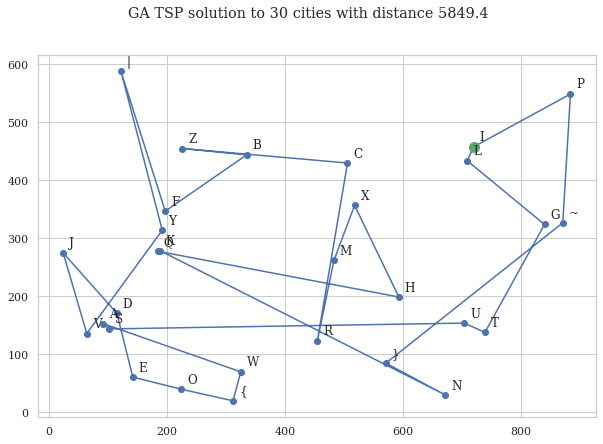

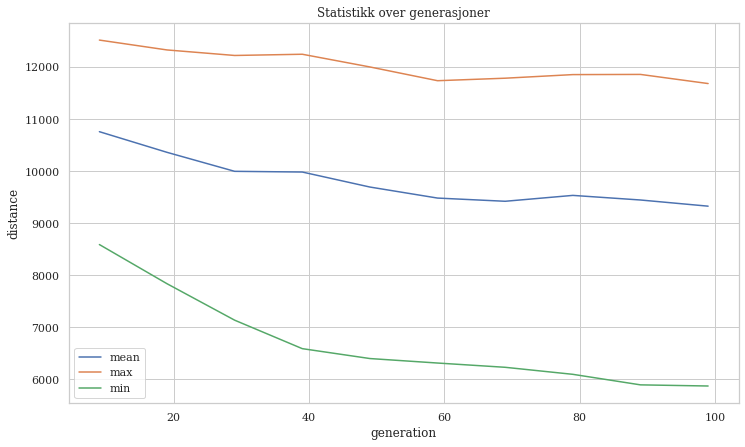

In [12]:
# Not all parameters here are necessarily relevant for you
# You must define your own parameters
# Run the code, and you'll quickly get an error message if some parameter is missing.
params = {
    # survival
    "keep_elite_fraction": 0.05,

    # selection
    "tournament_size": 3,
    "tournament_winners": 1,

    # mutation
    "mutation_probability": 0.1,

    # GA
    "generations": 100,
    "population_size": 100
}

number_of_cities = 30
cities = generate_cities(number_of_cities)
best_solution, stats = tsp(cities, params)

plot_tour(tour = best_solution.tour)
plot_statistics(stats = stats, columns = ["mean", "max", "min"], smoothing_window=10)

# Bra jobbet

Det finnes flere og bedre metoder enn de som er implementert. Om du har kommet så langt og kjeder deg så kan dere se på nett om dere optimale algoritmer for å løse problemet